# [실습] LangGraph의 다양한 State 활용하기    


이전 실습에서는 하나의 클래스에 문자열, 정수와 같은 값을 정의하고, 이를 모든 노드가 공유하도록 구성했는데요.   

이번 실습에서는 State를 보다 복잡하게 만들어 보겠습니다.   





In [1]:
!pip install langgraph langchain langchain_google_genai langchain_community

In [2]:
import os
os.environ['GOOGLE_API_KEY'] = 'AIxxx'

from langchain_core.rate_limiters import InMemoryRateLimiter
from langchain_google_genai import ChatGoogleGenerativeAI

# Gemini API는 분당 10개 요청으로 제한
# 즉, 초당 약 0.167개 요청 (10/60)
rate_limiter = InMemoryRateLimiter(
    requests_per_second=0.167,  # 분당 10개 요청
    check_every_n_seconds=0.1,  # 100ms마다 체크
    max_bucket_size=10,  # 최대 버스트 크기
)

# rate limiter를 LLM에 적용
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    rate_limiter=rate_limiter,
    # temperature
    # max_tokens

    thinking_budget = 500  # 추론(Reasoning) 토큰 길이 제한
)

## 1. 구조화된 출력 State에 적용하기

LangChain의 `llm.with_structured_output`을 사용하면, 구조화된 출력을 만들 수 있습니다.   
Pydantic을 이용해, 예시 데이터의 구조를 만들어 보겠습니다.

In [3]:
from pydantic import BaseModel, Field

# 프롬프트 자동 생성을 위한 요소 저장
class Objective(BaseModel):
    instruction: str = Field(description='프롬프트의 지시 사항을 명확히 재구성')
    output_format: str = Field(description='출력 포맷에 대한 설명')
    examples: str = Field(description='예시 출력(1개)')
    notes: str = Field(description='작업 과정에서 중요한 내용을 4개의 개조식 문장으로 구성')

    @property #
    def as_str(self) -> str:
        return '\n\n'.join([f'## {key}\n {value}' for key, value in self])


In [4]:
from langchain_core.prompts import ChatPromptTemplate
prompt = ChatPromptTemplate([
    ('system', '아래의 작업을 보다 자세하게 요청하는 시스템 프롬프트를 구성하고자 합니다. 주어진 포맷에 적절하게 작성하세요.'),
    ('user', '{instruction}')

])

chain = prompt | llm.with_structured_output(Objective)

result = chain.invoke("집에서 쉽게 구할 수 있는 재료로 재미있는 장난감 만들기")

result

Objective(instruction='사용자가 집에서 쉽게 구할 수 있는 재료를 활용하여 만들 수 있는 재미있는 장난감 아이디어를 제안하고, 해당 장난감을 만드는 데 필요한 준비물과 구체적인 제작 방법을 단계별로 설명해주세요.', output_format='다음과 같은 JSON 형식으로 출력합니다:\n```json\n{\n  "장난감 이름": "장난감 이름",\n  "준비물": [\n    "재료 1",\n    "재료 2",\n    "..."\n  ],\n  "만드는 방법": [\n    "단계 1",\n    "단계 2",\n    "..."\n  ]\n}\n```', examples='```json\n{\n  "장난감 이름": "휴지심 망원경",\n  "준비물": [\n    "휴지심 (2개 이상)",\n    "색종이 또는 포장지",\n    "가위",\n    "풀 또는 양면테이프",\n    "끈 (선택 사항)"\n  ],\n  "만드는 방법": [\n    "1. 휴지심 한쪽 끝에 가위로 4등분하여 1cm 정도 깊이로 자릅니다.",\n    "2. 다른 휴지심의 한쪽 끝을 1번 휴지심에 끼울 수 있도록 살짝 오므립니다.",\n    "3. 두 휴지심을 연결하여 망원경 모양을 만듭니다. 풀이나 테이프로 고정합니다.",\n    "4. 색종이나 포장지로 망원경을 예쁘게 꾸며줍니다.",\n    "5. (선택 사항) 망원경 양쪽에 구멍을 뚫어 끈을 연결하면 목에 걸고 다닐 수 있습니다."\n  ]\n}\n```', notes='1.  장난감 제작 시 아이들의 안전을 최우선으로 고려하여 날카로운 도구나 유해 물질 사용은 피하도록 안내합니다.\n2.  집에서 흔히 찾을 수 있는 재료(예: 휴지심, 종이컵, 신문지, 고무줄, 페트병 등) 위주로 아이디어를 제안합니다.\n3.  만드는 방법은 어린아이도 이해할 수 있도록 쉽고 명확하며 구체적인 단계로 구성합니다.\n4.  만들어진 장난감으로 어떤 놀이를 할 수 있는지 간단한 팁을 추가하여 재미를 더할 수 

In [5]:
print(result.as_str)

## instruction
 사용자가 집에서 쉽게 구할 수 있는 재료를 활용하여 만들 수 있는 재미있는 장난감 아이디어를 제안하고, 해당 장난감을 만드는 데 필요한 준비물과 구체적인 제작 방법을 단계별로 설명해주세요.

## output_format
 다음과 같은 JSON 형식으로 출력합니다:
```json
{
  "장난감 이름": "장난감 이름",
  "준비물": [
    "재료 1",
    "재료 2",
    "..."
  ],
  "만드는 방법": [
    "단계 1",
    "단계 2",
    "..."
  ]
}
```

## examples
 ```json
{
  "장난감 이름": "휴지심 망원경",
  "준비물": [
    "휴지심 (2개 이상)",
    "색종이 또는 포장지",
    "가위",
    "풀 또는 양면테이프",
    "끈 (선택 사항)"
  ],
  "만드는 방법": [
    "1. 휴지심 한쪽 끝에 가위로 4등분하여 1cm 정도 깊이로 자릅니다.",
    "2. 다른 휴지심의 한쪽 끝을 1번 휴지심에 끼울 수 있도록 살짝 오므립니다.",
    "3. 두 휴지심을 연결하여 망원경 모양을 만듭니다. 풀이나 테이프로 고정합니다.",
    "4. 색종이나 포장지로 망원경을 예쁘게 꾸며줍니다.",
    "5. (선택 사항) 망원경 양쪽에 구멍을 뚫어 끈을 연결하면 목에 걸고 다닐 수 있습니다."
  ]
}
```

## notes
 1.  장난감 제작 시 아이들의 안전을 최우선으로 고려하여 날카로운 도구나 유해 물질 사용은 피하도록 안내합니다.
2.  집에서 흔히 찾을 수 있는 재료(예: 휴지심, 종이컵, 신문지, 고무줄, 페트병 등) 위주로 아이디어를 제안합니다.
3.  만드는 방법은 어린아이도 이해할 수 있도록 쉽고 명확하며 구체적인 단계로 구성합니다.
4.  만들어진 장난감으로 어떤 놀이를 할 수 있는지 간단한 팁을 추가하여 재미를 더할 수 있습니다.


위에서 만든 Objective Class는 State의 단일 값으로도 저장할 수 있습니다.

In [6]:
from typing import TypedDict

class State(TypedDict):
    instruction : str
    prompt_materials : Objective # Objective Class를 하나의 값에 저장
    full_prompt : str
    result : str

In [7]:
def get_prompt_materials(State):
    prompt = ChatPromptTemplate([
        ('system', '아래의 작업을 보다 자세하게 세분화하고자 합니다. 주어진 포맷에 적절하게 작성하세요.'),
        ('user', '{instruction}')

    ])

    chain = prompt | llm.with_structured_output(Objective)

    result = chain.invoke({'instruction':State['instruction']})
    return {'prompt_materials' : result}


In [8]:
from langchain_core.output_parsers import StrOutputParser

def generate_prompt(State):
    prompt = ChatPromptTemplate([
        ('system', '''당신은 체계적이고 정확한 프롬프트 엔지니어입니다. 아래의 포인트를 바탕으로, LLM에 입력할  시스템 프롬프트를 작성하세요.
{points}'''),
        ('user', '{instruction}')
    ])

    chain = prompt | llm | StrOutputParser()

    result = chain.invoke({'instruction': State['instruction'], 'points': State['prompt_materials'].as_str})
    return {'full_prompt' : result}


In [9]:
def generate(State):
    return {'result' : llm.invoke(State['full_prompt']).content}

In [10]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END


# 그래프 구성
builder = StateGraph(State)

builder.add_node("get_prompt_materials", get_prompt_materials)
builder.add_node("generate_prompt", generate_prompt)
builder.add_node("generate", generate)

builder.add_edge(START, "get_prompt_materials")
builder.add_edge("get_prompt_materials", "generate_prompt")
builder.add_edge("generate_prompt", "generate")

builder.add_edge("generate", END)


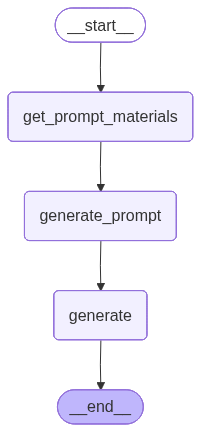

In [11]:
graph = builder.compile()
graph

In [12]:
import pprint

# Streaming 참고
# https://langchain-ai.github.io/langgraph/concepts/streaming/#streaming-graph-outputs-stream-and-astream

for data in graph.stream({'instruction': '''영화 '마이너리티 리포트'와 AI 윤리의 연관성에 대한 리포트 쓰기'''},
                         stream_mode='values'):
    pprint.pprint(data)
    print('----')

{'instruction': "영화 '마이너리티 리포트'와 AI 윤리의 연관성에 대한 리포트 쓰기"}
----
{'instruction': "영화 '마이너리티 리포트'와 AI 윤리의 연관성에 대한 리포트 쓰기",
 'prompt_materials': Objective(instruction="영화 '마이너리티 리포트'의 핵심 내용과 AI 윤리(프라이버시 침해, 알고리즘 편향, 자유 의지 문제 등) 간의 연관성을 심층적으로 분석하고, 이를 바탕으로 AI 기술 발전이 가져올 수 있는 사회적, 윤리적 함의에 대한 보고서를 작성하세요.", output_format='보고서는 서론, 본론(영화 내용 요약 및 AI 윤리 문제 분석), 결론으로 구성되어야 합니다. 각 섹션은 명확한 소제목과 함께 논리적으로 전개되어야 합니다.', examples="서론: '마이너리티 리포트'는 예측 기술이 인간 사회에 미치는 영향을 탐구하며, 현대 AI 윤리 논의에 중요한 시사점을 제공한다. 본론: 1. 예측 범죄 시스템의 윤리적 딜레마 - 영화 속 '프리크라임' 시스템은 개인의 자유 의지와 프라이버시를 침해할 수 있는 예측 알고리즘의 위험성을 보여준다. ... 결론: '마이너리티 리포트'는 AI 기술이 가져올 수 있는 유토피아와 디스토피아적 미래를 동시에 제시하며, AI 윤리 원칙 수립의 중요성을 강조한다.", notes="* 영화 '마이너리티 리포트'의 주요 줄거리와 설정 중 AI 윤리 문제와 직결되는 부분을 명확히 요약해야 합니다.\n* 프라이버시 침해, 알고리즘 편향, 자유 의지, 책임 소재 등 구체적인 AI 윤리 쟁점을 영화의 사례와 연결하여 분석해야 합니다.\n* 영화가 제시하는 가상의 시나리오가 현실의 AI 개발 및 적용에 어떤 시사점을 주는지 현실적인 관점에서 서술해야 합니다.\n* 보고서의 논리적 흐름과 일관성을 유지하며, 각 주장에 대한 근거를 명확히 제시해야 합니다.")}
----
{'full_prompt': '다음은 LLM에 입력할 시스템 프롬프트입니다.\n'
     

In [13]:
data

{'instruction': "영화 '마이너리티 리포트'와 AI 윤리의 연관성에 대한 리포트 쓰기",
 'prompt_materials': Objective(instruction="영화 '마이너리티 리포트'의 핵심 내용과 AI 윤리(프라이버시 침해, 알고리즘 편향, 자유 의지 문제 등) 간의 연관성을 심층적으로 분석하고, 이를 바탕으로 AI 기술 발전이 가져올 수 있는 사회적, 윤리적 함의에 대한 보고서를 작성하세요.", output_format='보고서는 서론, 본론(영화 내용 요약 및 AI 윤리 문제 분석), 결론으로 구성되어야 합니다. 각 섹션은 명확한 소제목과 함께 논리적으로 전개되어야 합니다.', examples="서론: '마이너리티 리포트'는 예측 기술이 인간 사회에 미치는 영향을 탐구하며, 현대 AI 윤리 논의에 중요한 시사점을 제공한다. 본론: 1. 예측 범죄 시스템의 윤리적 딜레마 - 영화 속 '프리크라임' 시스템은 개인의 자유 의지와 프라이버시를 침해할 수 있는 예측 알고리즘의 위험성을 보여준다. ... 결론: '마이너리티 리포트'는 AI 기술이 가져올 수 있는 유토피아와 디스토피아적 미래를 동시에 제시하며, AI 윤리 원칙 수립의 중요성을 강조한다.", notes="* 영화 '마이너리티 리포트'의 주요 줄거리와 설정 중 AI 윤리 문제와 직결되는 부분을 명확히 요약해야 합니다.\n* 프라이버시 침해, 알고리즘 편향, 자유 의지, 책임 소재 등 구체적인 AI 윤리 쟁점을 영화의 사례와 연결하여 분석해야 합니다.\n* 영화가 제시하는 가상의 시나리오가 현실의 AI 개발 및 적용에 어떤 시사점을 주는지 현실적인 관점에서 서술해야 합니다.\n* 보고서의 논리적 흐름과 일관성을 유지하며, 각 주장에 대한 근거를 명확히 제시해야 합니다."),
 'full_prompt': "다음은 LLM에 입력할 시스템 프롬프트입니다.\n\n---\n\n**시스템 프롬프트:**\n\n당신은 영화 '마이너리티 리포트'의 심층적인 분석가이자 AI 윤리 전문가입니다. 주어진

In [14]:
from IPython.display import display
from IPython.display import Markdown
import textwrap

def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

to_markdown(data['result'])


> # 영화 '마이너리티 리포트'와 AI 윤리의 심층 분석 보고서
> 
> ## 서론: 예측 기술과 AI 윤리 논의의 교차점
> 
> 스티븐 스필버그 감독의 2002년작 영화 '마이너리티 리포트'는 2054년 워싱턴 D.C.를 배경으로, 범죄가 발생하기 전에 예측하여 미리 막는 '프리크라임(PreCrime)' 시스템이 완벽하게 작동하는 사회를 그린다. 이 시스템은 '프리코그(Precog)'라 불리는 세 명의 예지능력자들의 예측에 기반하며, 살인 사건을 미연에 방지하여 범죄율을 현저히 낮추는 데 성공한다. 그러나 영화는 이러한 유토피아적 표면 아래에 숨겨진 심각한 윤리적 딜레마들을 탐구하며, AI 기술의 발전이 인류 사회에 가져올 수 있는 빛과 그림자를 동시에 비춘다. 단순한 SF 스릴러를 넘어, '마이너리티 리포트'는 현대 AI 윤리 논의의 핵심 쟁점인 프라이버시 침해, 자유 의지, 알고리즘 편향, 책임 소재 등과 깊이 연결되어 있어, AI 기술 발전의 사회적, 윤리적 함의에 대한 심도 있는 통찰을 제공한다. 본 보고서는 AI 윤리 전문가의 관점에서 '마이너리티 리포트'를 분석하고, 영화가 제시하는 가상의 시나리오가 현실의 AI 기술 개발 및 적용에 어떠한 중요한 시사점과 경고를 주는지 탐색하고자 한다.
> 
> ## 본론: '마이너리티 리포트'가 제시하는 AI 윤리적 딜레마
> 
> ### 1. 영화 '마이너리티 리포트' 핵심 내용 요약
> 
> 영화 '마이너리티 리포트'는 예측 기술이 지배하는 근미래 사회를 배경으로 한다. 핵심 설정과 줄거리는 다음과 같다.
> 
> *   **프리크라임 시스템의 작동 방식 및 핵심 설정:**
>     워싱턴 D.C.의 프리크라임 시스템은 세 명의 '프리코그'라 불리는 예지능력자들의 집단적 예측을 통해 미래의 살인 사건을 미리 감지한다. 이들은 일종의 초지능 AI 시스템과 유사하게 작동하며, 범죄가 일어날 장소, 시간, 가해자와 피해자를 정확히 예측한다. 프리크라임 요원들은 이 예측 정보를 바탕으로 범죄 현장에 출동하여 범죄가 일어나기 직전 범인을 체포하고, 체포된 '예비 범죄자'들은 특별한 감옥에 수감된다. 이 시스템 덕분에 D.C.에서는 6년 동안 살인 사건이 단 한 건도 발생하지 않아, 사회 안전의 상징으로 여겨진다. 이 시스템의 성공은 예측 기술이 가져올 수 있는 사회적 효율성과 안전이라는 이상적인 비전을 제시한다.
> 
> *   **프리코그와 '마이너리티 리포트'의 존재:**
>     프리코그들은 어릴 적 트라우마로 인해 미래를 볼 수 있는 능력을 갖게 된 존재들로, 특수 시설에 격리되어 시스템의 핵심 역할을 수행한다. 이들의 예측은 보통 세 가지 동일한 미래를 보지만, 때로는 세 명 중 한 명이 다른 미래를 예측하는 경우가 발생한다. 이처럼 소수의 프리코그가 다른 예측을 내놓는 경우, 이를 '마이너리티 리포트'라고 부른다. 시스템 운영진은 대다수의 의견을 따라 소수의 예측을 무시하거나 은폐하는 경향이 있는데, 이는 시스템의 '완벽성'을 유지하려는 시도이자 동시에 시스템의 근본적인 오류 가능성과 편향성을 내포한다. 주인공 존 앤더튼이 자신이 미래의 살인범으로 예측되면서, 이 '마이너리티 리포트'의 존재를 파헤치게 되고, 시스템의 완벽성이 사실은 조작과 은폐 위에 세워진 허상임을 깨닫게 된다.
> 
> ### 2. AI 윤리 문제 분석: 영화 속 사례를 중심으로
> 
> '마이너리티 리포트'는 AI 윤리 분야의 주요 쟁점들을 영화 속 구체적인 사례를 통해 생생하게 보여준다.
> 
> *   **2.1. 프라이버시 침해와 감시 사회의 도래**
>     영화 속 2054년 사회는 고도로 발전된 감시 기술로 개인의 일거수일투족이 추적당하는 '감시 사회'의 극단적인 형태를 보여준다. 가장 대표적인 것이 홍채 인식 시스템이다. 상점 진열대는 고객의 홍채를 인식하여 개인 맞춤형 광고를 띄우고, 거리 곳곳의 스캐너는 시민들의 신원을 실시간으로 파악한다. 주인공 존 앤더튼이 도주하는 과정에서 홍채를 바꾸고 변장해야만 추적을 피할 수 있었던 장면은, 예측 시스템이 개인의 신원과 과거 정보를 어떻게 손쉽게 열람하고 활용하며 프라이버시를 침해하는지 극명하게 보여준다. 프리크라임 시스템 자체가 개인의 '생각'이나 '의도'를 예측하여 체포하는 방식이므로, 이는 개인의 가장 내밀한 영역까지 감시하고 통제하려는 시도로 볼 수 있다. AI 기반의 안면 인식, 위치 추적, 행동 패턴 분석 기술이 현실에서 발전함에 따라, 영화 속 감시 사회는 더 이상 먼 미래의 이야기가 아님을 경고하며, 개인 정보 보호와 사생활의 권리가 얼마나 취약해질 수 있는지를 상기시킨다.
> 
> *   **2.2. 자유 의지 박탈과 예측 기반의 정의**
>     프리크라임 시스템의 가장 근본적인 윤리적 문제는 '자유 의지'의 박탈이다. 개인이 실제로 범죄를 저지르기 전에 '미래의 범죄자'로 낙인찍혀 체포되는 것은, 인간이 자신의 행동을 선택하고 그에 대한 책임을 질 수 있는 기본적인 '선택의 권리'를 박탈하는 행위다. 영화는 존 앤더튼이 미래에 살인을 저지를 것이라는 예측을 받고 도주하는 과정에서, 그가 자신의 미래를 바꾸기 위해 필사적으로 노력하는 모습을 통해 자유 의지의 중요성을 강조한다. 프리코그의 예측이 절대적인 미래를 의미하는지, 아니면 바뀔 수 있는 가능성 중 하나인지에 대한 질문은 인간의 자율성과 존엄성에 대한 심각한 물음을 던진다. 만약 미래가 확정되어 있다면 인간의 노력과 선택은 무의미해지며, 이는 인간 존재의 의미를 근본적으로 뒤흔든다. 예측에 기반한 체포는 '범죄'가 아닌 '범죄 의도'에 대한 처벌이며, 이는 형법의 대원칙인 '행위 책임의 원칙'과 정면으로 충돌한다.
> 
> *   **2.3. 알고리즘 편향 및 오류 가능성의 경고**
>     '마이너리티 리포트'라는 제목 자체가 예측 시스템의 '알고리즘 편향'과 '오류 가능성'을 상징한다. 프리코그 세 명의 예측이 일치하지 않을 때 발생하는 '마이너리티 리포트'는 시스템이 완벽하지 않으며, 소수의 의견이나 예외 상황을 무시할 수 있음을 보여준다. 영화 속에서 이 '마이너리티 리포트'는 시스템의 오류를 은폐하고 완벽하다는 환상을 유지하기 위해 의도적으로 삭제되거나 무시된다. 이는 현실의 AI 알고리즘이 겪을 수 있는 '데이터 편향'이나 '블랙박스 문제'와 유사하다. 학습 데이터에 특정 편향이 존재하거나, 소수 집단의 특성이 충분히 반영되지 않으면, AI는 특정 집단에 대해 불공정한 예측이나 결정을 내릴 수 있다. 프리코그들의 예측 불일치는 AI 모델이 항상 완벽한 답을 내놓지 않으며, 불확실성과 오류 가능성을 내포하고 있음을 시사한다. 시스템의 오류가 은폐될 경우, 무고한 사람이 희생되거나 사회적 불신이 커질 수 있다는 경고를 던진다.
> 
> *   **2.4. 책임 소재와 시스템의 윤리적 한계**
>     프리크라임 시스템과 같은 예측 기반 사법 시스템에서 가장 어려운 문제 중 하나는 '책임 소재'다. 미래의 범죄를 예측하고 체포하는 결정이 프리코그의 능력에 기반한다면, 예측이 잘못되었을 경우 그 책임은 누구에게 있는가? 프리코그 개인에게? 시스템을 설계한 개발자에게? 아니면 시스템을 운영하는 정부 기관에게? 영화는 존 앤더튼이 무고하게 '미래의 살인범'으로 지목되었을 때, 시스템의 절대성에 도전하며 진정한 책임자를 찾아 나서는 과정을 그린다. 예측에 기반한 처벌은 '정의'의 개념과 충돌한다. 범죄를 저지르지 않은 사람을 처벌하는 것이 과연 정의로운가? 시스템이 완벽하다는 전제하에 운영되지만, 그 완벽성이 허상임이 드러났을 때, 시스템에 대한 신뢰는 무너지고 사회적 혼란이 야기된다. 이는 AI 시스템이 내린 결정에 대한 윤리적, 법적 책임은 누가 져야 하는지에 대한 중요한 질문을 던지며, 시스템의 절대성을 맹신하는 것의 위험성을 경고한다.
> 
> ### 3. 현실의 AI 기술과 '마이너리티 리포트'의 시사점
> 
> '마이너리티 리포트'가 제시하는 가상의 시나리오는 오늘날 급속도로 발전하는 AI 기술, 특히 예측 분석과 감시 기술의 현실 적용에 대한 중요한 시사점과 경고를 제공한다.
> 
> *   **예측 사법, 감시 기술 등에 대한 현실적 경고:**
>     현실에서는 이미 '예측 사법(Predictive Policing)' 시스템이 일부 도시에서 범죄 발생 가능성이 높은 지역이나 개인을 예측하는 데 활용되고 있다. 안면 인식 기술, CCTV, 드론을 이용한 감시는 영화 속 홍채 인식 시스템처럼 개인의 동선을 추적하고 신원을 파악하는 데 사용되며, 이는 잠재적인 감시 사회로의 이행 가능성을 보여준다. 또한, 신용 평가 시스템, 채용 과정의 AI 평가, 대출 심사 등 다양한 분야에서 AI 알고리즘이 개인의 미래를 예측하고 중요한 결정을 내리는 데 활용되고 있다. 이러한 시스템들은 효율성을 증대시키고 위험을 줄이는 데 기여할 수 있지만, 영화가 경고하듯이 프라이버시 침해, 알고리즘 편향으로 인한 차별, 그리고 개인의 자유 의지 제약과 같은 심각한 윤리적 문제를 야기할 수 있다.
> 
> *   **AI 개발 및 적용에 대한 윤리적 고려의 필요성:**
>     영화는 기술 발전이 가져올 수 있는 잠재적 위험에 대한 강력한 경고 메시지를 전달한다. AI 기술은 단순히 기술적 완벽성을 추구하는 것을 넘어, 사회적, 윤리적 가치를 함께 고려해야 함을 역설한다. 예측 알고리즘의 한계와 오류 가능성을 인지하고, 이에 대한 투명성과 설명 가능성을 확보해야 한다. 또한, 개인의 프라이버시와 자유 의지를 존중하며, 알고리즘이 특정 집단에 대한 편향된 결과를 초래하지 않도록 공정성을 확보하는 것이 중요하다. '마이너리티 리포트'는 AI 기술이 인류에게 진정한 혜택을 주기 위해서는 기술적 진보만큼이나 사회적 합의와 윤리적 원칙 수립이 선행되어야 함을 강조하며, AI 개발자와 정책 입안자들에게 기술의 남용을 경계하고 책임감 있는 개발을 촉구하는 강력한 메시지를 던진다.
> 
> ## 결론: AI 시대의 윤리적 나침반을 찾아서
> 
> 영화 '마이너리티 리포트'는 예측 기술과 AI의 발전이 인류에게 가져올 수 있는 유토피아적 희망과 디스토피아적 그림자를 동시에 제시하며, 기술이 만능이 아님을 역설한다. 이 영화는 프리크라임 시스템을 통해 프라이버시 침해, 자유 의지 박탈, 알고리즘 편향 및 오류 가능성, 그리고 책임 소재의 문제와 같은 현대 AI 윤리 논의의 핵심 쟁점들을 선명하게 보여준다. 특히, '마이너리티 리포트'의 존재는 AI 시스템의 완벽성에 대한 맹신이 얼마나 위험할 수 있는지, 그리고 소수의 의견이나 예외 상황이 간과될 때 어떤 비극적 결과를 초래할 수 있는지를 강력히 경고한다.
> 
> 우리가 AI 시대로 나아가면서, '마이너리티 리포트'는 단순히 허구의 이야기를 넘어 현실의 AI 개발 및 적용에 대한 중요한 윤리적 나침반 역할을 한다. 예측 사법, 감시 기술, 개인 맞춤형 알고리즘 등이 일상화되는 시대에, 우리는 기술의 효율성만을 좇을 것이 아니라 인간의 존엄성, 자율성, 그리고 사회적 정의라는 근본적인 가치를 어떻게 보호하고 증진할 것인지 끊임없이 질문해야 한다. 투명하고 공정하며 책임감 있는 AI 개발과 적용을 위한 윤리적 원칙 수립은 선택이 아닌 필수다. 영화가 주는 강력한 메시지처럼, 미래 AI 기술이 인류에게 진정한 혜택을 주기 위해서는 기술적 진보만큼이나 사회적, 윤리적 고려가 선행되어야 하며, 우리가 어떤 미래를 만들 것인지는 지금 우리의 윤리적 선택에 달려 있음을 이 영화는 강력히 시사한다.

이와 같이 구조화된 출력을 연결하여, 그래프의 중간, 혹은 최종 출력물을 구성할 수 있습니다.

## 2. Message 포맷의 State 사용하기

State의 저장값으로 Message를 바로 사용하기도 합니다.   
이 경우, Context에 메시지를 계속 추가하거나, 별도의 로직을 만들어 메시지 정보를 전달합니다.

`typing`의 `Annotated`로 공간을 지정한 후, 뒷부분에 결합 로직을 포함합니다.   
이를 리듀서(Reducer)라고 부르는데, 메시지의 경우 아래와 같이 포함하면 됩니다.

In [18]:
from typing import Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# add_messages: 메시지를 계속 뒤에 추가하는 방식
# 기존 메시지를 수정하거나, 삭제하는 것도 가능합니다.

class State(TypedDict):
    context : Annotated[list, add_messages]

이번에는 메시지를 주고받는 형태를 구성해 보겠습니다.   

In [19]:
def talk(State):
    return {'context': AIMessage(content='AI 메시지 2')}


builder = StateGraph(State)
builder.add_node('talk',talk)
builder.add_edge(START, 'talk')
builder.add_edge('talk', END)





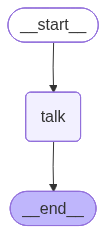

In [20]:
graph = builder.compile()
graph

In [21]:
messages = [
    SystemMessage(content='시스템 메시지 1'),
    HumanMessage(content='유저 메시지 1'),
    AIMessage(content='AI 메시지 1'),
    HumanMessage(content='유저 메시지 2'),
]

response = graph.invoke({'context': messages})
response

{'context': [SystemMessage(content='시스템 메시지 1', additional_kwargs={}, response_metadata={}, id='509db168-2077-40c5-afec-ff56f1ead7a4'),
  HumanMessage(content='유저 메시지 1', additional_kwargs={}, response_metadata={}, id='2d09c8c1-9ded-463b-967b-2b2f3b3e4742'),
  AIMessage(content='AI 메시지 1', additional_kwargs={}, response_metadata={}, id='930112b2-3cb1-48e4-ae46-f57affb9088e'),
  HumanMessage(content='유저 메시지 2', additional_kwargs={}, response_metadata={}, id='36e26f02-1f64-43ae-98df-c61f633f59b4'),
  AIMessage(content='AI 메시지 2', additional_kwargs={}, response_metadata={}, id='748c06b6-f860-4f81-8089-12097dd15f5a')]}

전체 Context를 모두 저장하는 위와 같은 방식도 가능하지만,   
`RemoveMessage`를 사용하여 메시지를 제거할 수도 있습니다.

In [22]:
from langchain_core.messages import RemoveMessage
def delete_message(State):
    # 첫번째,두번째 메시지 삭제
    messages = State['context']
    return {"context": [RemoveMessage(id = messages[i].id) for i in range(1,3)]}


In [23]:
builder = StateGraph(State)

builder.add_node('talk',talk)
builder.add_node('delete_message',delete_message)

builder.add_edge(START, 'talk')
builder.add_edge('talk', 'delete_message')
builder.add_edge('delete_message', END)

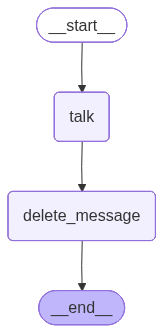

In [24]:
graph = builder.compile()
graph

In [25]:
messages

[SystemMessage(content='시스템 메시지 1', additional_kwargs={}, response_metadata={}, id='509db168-2077-40c5-afec-ff56f1ead7a4'),
 HumanMessage(content='유저 메시지 1', additional_kwargs={}, response_metadata={}, id='2d09c8c1-9ded-463b-967b-2b2f3b3e4742'),
 AIMessage(content='AI 메시지 1', additional_kwargs={}, response_metadata={}, id='930112b2-3cb1-48e4-ae46-f57affb9088e'),
 HumanMessage(content='유저 메시지 2', additional_kwargs={}, response_metadata={}, id='36e26f02-1f64-43ae-98df-c61f633f59b4')]

In [26]:
# 유저 메시지 1, AI 메시지 1 삭제

graph.invoke({'context': messages})

{'context': [SystemMessage(content='시스템 메시지 1', additional_kwargs={}, response_metadata={}, id='509db168-2077-40c5-afec-ff56f1ead7a4'),
  HumanMessage(content='유저 메시지 2', additional_kwargs={}, response_metadata={}, id='36e26f02-1f64-43ae-98df-c61f633f59b4'),
  AIMessage(content='AI 메시지 2', additional_kwargs={}, response_metadata={}, id='78aba47a-fd3d-4c2c-bb2e-a779164c8f4d')]}

위 방식으로 긴 컨텍스트를 저장할 때 일부만을 저장하거나, 앞 부분의 컨텍스트를 수정하여 저장할 수 있습니다.   
반복 기능을 추가한다면, 긴 컨텍스트의 대화도 효과적으로 만들 수 있습니다.